In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearnex.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearnex.svm import SVC
from sklearnex.ensemble import RandomForestClassifier
from sklearnex.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

# Data Prep

In [2]:
from sklearn.preprocessing import StandardScaler
data = pd.read_csv("../Data/cleaned_loan_data.csv")

In [3]:
from sklearn.model_selection import train_test_split
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=142, stratify=y)

In [4]:
std = StandardScaler().fit(X_train)
X_train = std.transform(X_train)
X_test = std.transform(X_test)

In [5]:
from sklearn.utils import resample
from sklearn.base import BaseEstimator, ClassifierMixin
class VotingClassifierCustom(BaseEstimator, ClassifierMixin):
    def __init__(self, algorithm_list, params=None, subsample=0.625, n_estimators=100, random_state=42, n_jobs=2):
        self.params = {type(key()).__name__: {} for key in algorithm_list}
        if params:
            for m, param in params.items():
                self.params[m] = param
        print(self.params) 
        self.subsample = subsample
        self.n_models = n_estimators // len(algorithm_list)
        self.n_estimators = self.n_models * len(algorithm_list)
        self.random_state=random_state
        self.n_jobs=n_jobs
        self.train_batches = []
        self.estimators = []
        self.models = algorithm_list
        
    def __generate_data_batches(self, X, y):
        n_sample = X.shape[0]
        subsample_size = int(n_sample* self.subsample)
        rng = np.random.RandomState(self.random_state)

        for _ in range(self.n_estimators):
            X_resampled, y_resampled = resample(X, y, n_samples=subsample_size, stratify=y, random_state=rng)
            self.train_batches.append((X_resampled, y_resampled))

    def __bagging_estimators(self):
        if len(self.models) == 1:
            self.models = self.models[0]
            self.estimators = [(f'clf{i}', self.models(**self.params[type(self.models()).__name__])) for i in range(self.n_estimators)]
        else:
            models = [m for m in self.models for _ in range(self.n_models)]
            self.estimators = [(f'clf{i}', model(**self.params[type(model()).__name__])) for i, model in enumerate(models)]
            
    def fit(self, X, y):
        self.__generate_data_batches(X, y)
        self.__bagging_estimators()
        for i, (X_train, y_train) in enumerate(tqdm(self.train_batches, desc="Training Estimators")):
            # print(type(self.estimators[i][1]).__name__, i)
            self.estimators[i][1].fit(X_train, y_train)
            
    def predict_proba(self, X):
        predictions = np.mean(np.array([model[1].predict_proba(X) for model in self.estimators]), axis=0)

        return predictions
    
    def predict(self, X, voting='soft'):
        if voting == 'soft':
            predictions = self.predict_proba(X)
            majority_votes = np.argmax(np.array(predictions), axis=1)
        if voting == 'hard':
            predictions = [model[1].predict(X) for model in self.estimators]
            majority_votes = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=predictions)
        return majority_votes
    

In [6]:
def model_eval(model, X_test, y_test, voting=None, roc_auc=True, prc=True):
    from sklearn.metrics import classification_report, confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import roc_curve
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import auc
    
    # Predict the labels
    if voting:
        y_pred = model.predict(X_test, voting)
    else:
        y_pred = model.predict(X_test)

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    if roc_auc is True or precision_recall_curve is True:
        y_pred_proba = model.predict_proba(X_test)
        pos_pred_proba = y_pred_proba[:, 1]
        
        if roc_auc is True:
            dummy_proba = [ 0 for _ in range(len(y_test))]
            dummy_auc = roc_auc_score(y_test, dummy_proba)
            predict_auc = roc_auc_score(y_test, pos_pred_proba)
            print('Baseline: ROC AUC=%.3f' % (dummy_auc))
            print('Model: ROC AUC=%.3f' % (predict_auc))
            # calculate roc curves
            ns_fpr, ns_tpr, _ = roc_curve(y_test, dummy_proba)
            lr_fpr, lr_tpr, _ = roc_curve(y_test, pos_pred_proba)
            # plot the roc curve for the model
            plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Baseline')
            plt.plot(lr_fpr, lr_tpr, marker='.', label='Model')
            # axis labels
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            # show the legend
            plt.legend()
            plt.title('ROC-AUC Curve')
            # show the plot
            plt.show() 
            
        if prc is True:
            model_precision, model_recall, _ = precision_recall_curve(y_test, pos_pred_proba)
            model_f1, model_auc = f1_score(y_test, y_pred), auc(model_recall, model_precision)
            # summarize scores
            print('Logistic: f1=%.3f auc=%.3f' % (model_f1, model_auc))
            # plot the precision-recall curves
            baseline = len(y_test[y_test==1]) / len(y_test)
            plt.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
            plt.plot(model_recall, model_precision, marker='.', label='Model')
            # axis labels
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            # show the legend
            plt.legend()
            plt.title('Precision-Recall Curve')
            # show the plot
            plt.show()
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred, normalize='all')

    # Display confusion matrix
    print("Confusion Matrix:")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()
    
    return cm



# Raw-Scaled

## Logistic Regression

In [7]:
logr = VotingClassifierCustom([LogisticRegression])
logr.fit(X_train, y_train)

{'LogisticRegression': {}}


Training Estimators: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


In [8]:
logr.predict(X_test, 'hard')

array([0, 0, 0, ..., 0, 0, 0])

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.66      0.34      0.45      1327

    accuracy                           0.82      6000
   macro avg       0.75      0.65      0.67      6000
weighted avg       0.80      0.82      0.79      6000

Baseline: ROC AUC=0.500
Model: ROC AUC=0.766


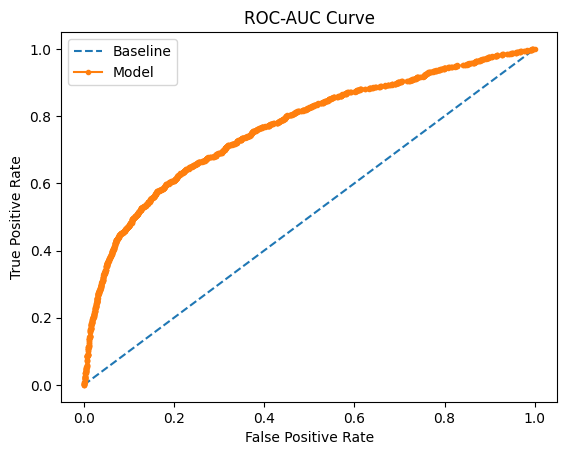

Logistic: f1=0.452 auc=0.531


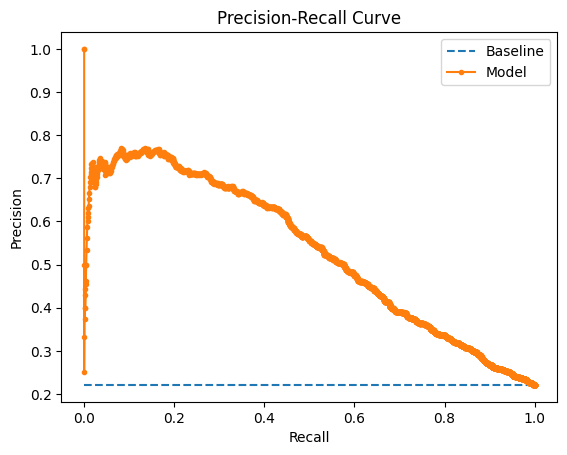

Confusion Matrix:


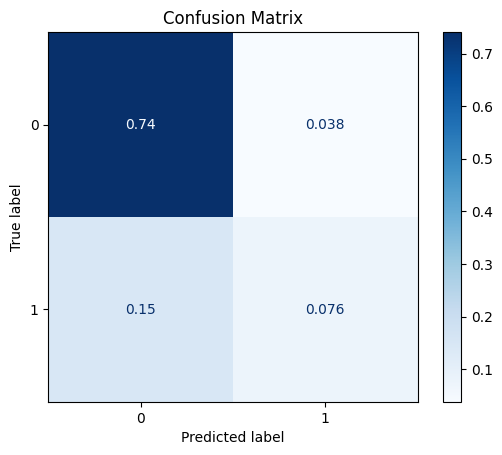

array([[0.74066667, 0.03816667],
       [0.1455    , 0.07566667]])

In [9]:
model_eval(logr, X_test, y_test, 'soft')

## Naive Bayes

In [10]:
gnb = VotingClassifierCustom([GaussianNB])
gnb.fit(X_train, y_train)

{'GaussianNB': {}}


Training Estimators: 100%|██████████| 100/100 [00:00<00:00, 339.14it/s]


In [11]:
gnb.predict(X_test, 'hard')

array([0, 0, 0, ..., 0, 0, 0])

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.82      0.85      4673
           1       0.48      0.57      0.52      1327

    accuracy                           0.77      6000
   macro avg       0.67      0.70      0.68      6000
weighted avg       0.78      0.77      0.77      6000

Baseline: ROC AUC=0.500
Model: ROC AUC=0.756


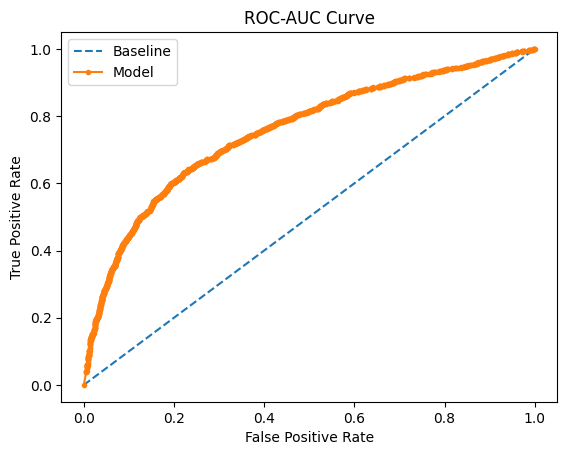

Logistic: f1=0.520 auc=0.506


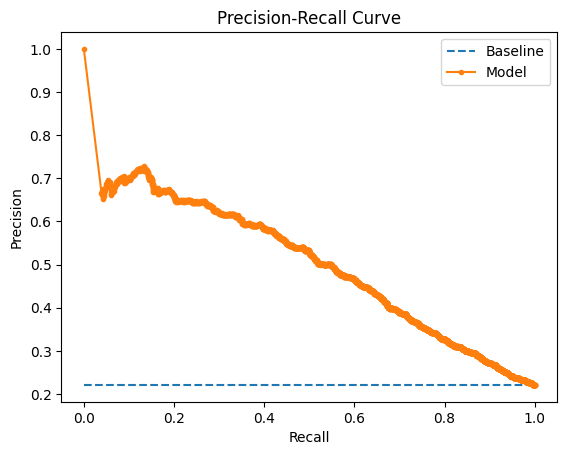

Confusion Matrix:


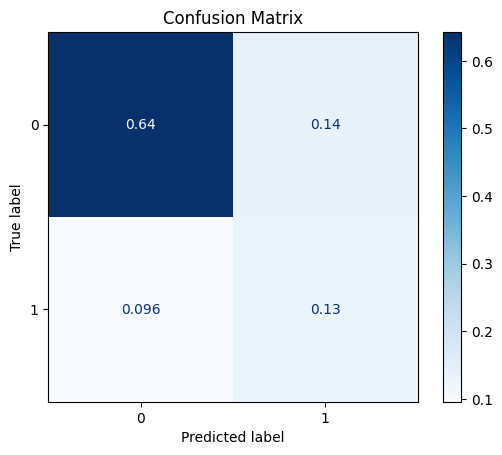

array([[0.6425    , 0.13633333],
       [0.09566667, 0.1255    ]])

In [12]:
model_eval(gnb, X_test, y_test, 'hard')


## KNN

In [13]:
knn = VotingClassifierCustom([KNeighborsClassifier])
knn.fit(X_train, y_train)

{'KNeighborsClassifier': {}}


Training Estimators: 100%|██████████| 100/100 [00:00<00:00, 470.63it/s]


In [14]:
knn.predict(X_test, 'hard')

array([0, 0, 0, ..., 0, 0, 0])

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      4673
           1       0.60      0.35      0.44      1327

    accuracy                           0.80      6000
   macro avg       0.72      0.64      0.66      6000
weighted avg       0.78      0.80      0.78      6000

Baseline: ROC AUC=0.500
Model: ROC AUC=0.732


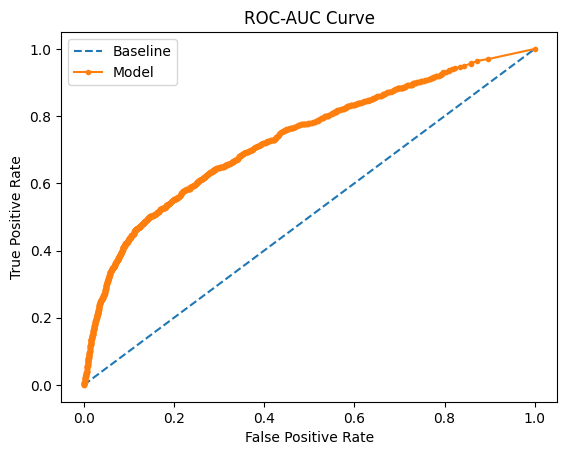

Logistic: f1=0.440 auc=0.481


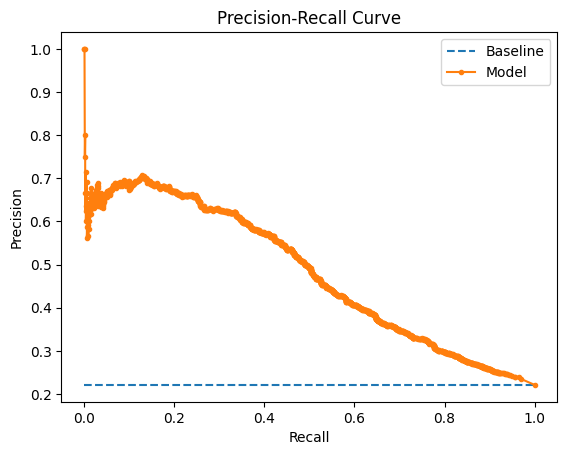

Confusion Matrix:


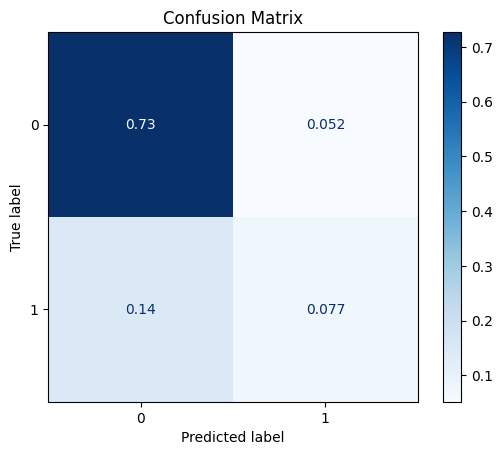

array([[0.72716667, 0.05166667],
       [0.14416667, 0.077     ]])

In [15]:
model_eval(knn, X_test, y_test, 'hard')

## SVM

In [16]:
SVM = VotingClassifierCustom([SVC], {'SVC': {'class_weight': 'balanced', 'probability': True}})
SVM.fit(X_train, y_train)
SVM.predict(X_test, 'hard')

{'SVC': {'class_weight': 'balanced', 'probability': True}}


Training Estimators: 100%|██████████| 100/100 [05:15<00:00,  3.16s/it]


array([0, 0, 0, ..., 0, 0, 0])

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      4673
           1       0.47      0.60      0.53      1327

    accuracy                           0.76      6000
   macro avg       0.68      0.71      0.69      6000
weighted avg       0.79      0.76      0.77      6000

Baseline: ROC AUC=0.500
Model: ROC AUC=0.774


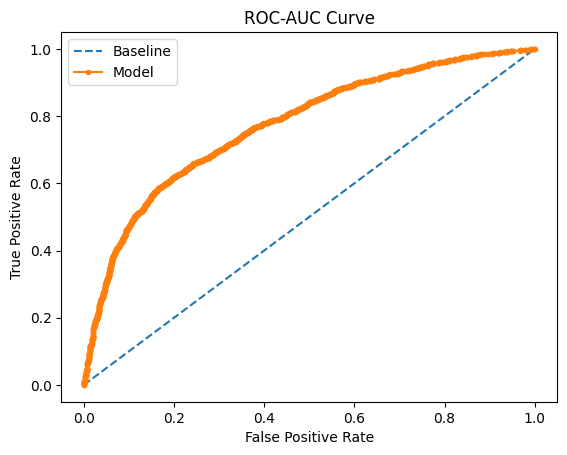

Logistic: f1=0.532 auc=0.512


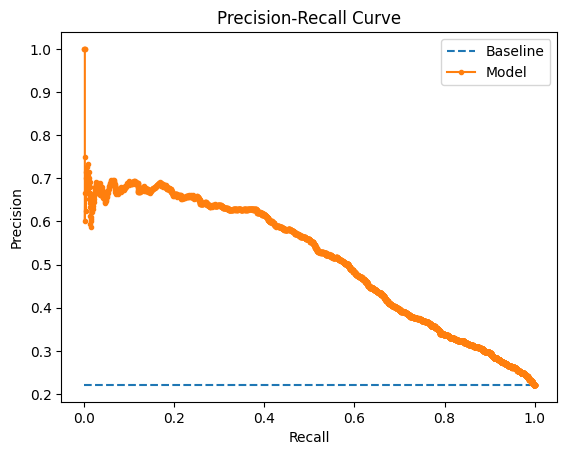

Confusion Matrix:


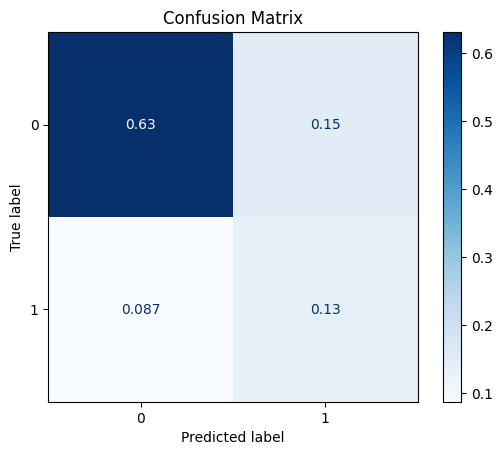

array([[0.631     , 0.14783333],
       [0.0875    , 0.13366667]])

In [17]:
model_eval(SVM, X_test, y_test, 'hard')

## Random Forest

In [18]:
rnf = RandomForestClassifier(n_estimators=100)
rnf.fit(X_train, y_train)
rnf.predict(X_test)

array([0, 0, 0, ..., 1, 0, 0])

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4673
           1       0.64      0.38      0.48      1327

    accuracy                           0.81      6000
   macro avg       0.74      0.66      0.68      6000
weighted avg       0.80      0.81      0.80      6000

Baseline: ROC AUC=0.500
Model: ROC AUC=0.763


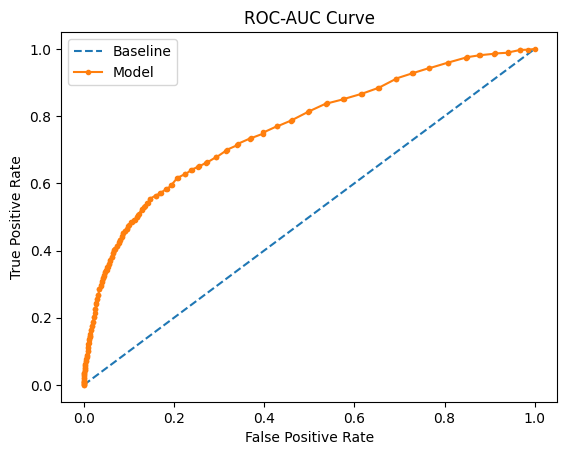

Logistic: f1=0.477 auc=0.541


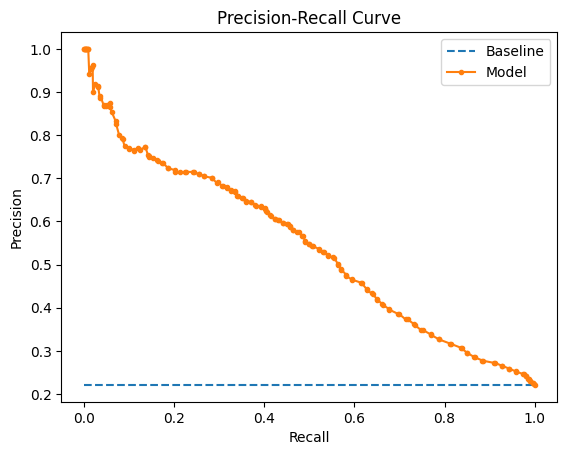

Confusion Matrix:


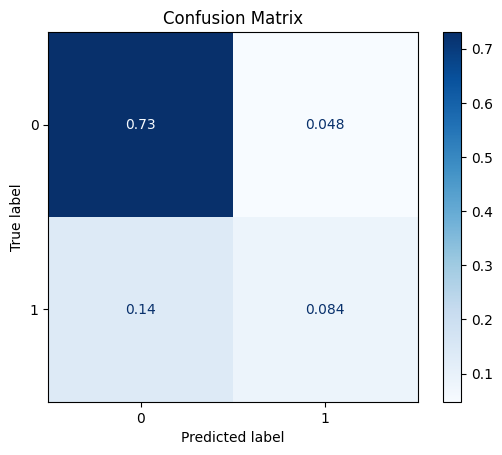

array([[0.73066667, 0.04816667],
       [0.13683333, 0.08433333]])

In [19]:
model_eval(rnf, X_test, y_test)

## Extra Trees


In [20]:
etc = ExtraTreesClassifier(n_estimators=100)
etc.fit(X_train, y_train)
etc.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      4673
           1       0.61      0.38      0.47      1327

    accuracy                           0.81      6000
   macro avg       0.73      0.66      0.68      6000
weighted avg       0.79      0.81      0.79      6000

Baseline: ROC AUC=0.500
Model: ROC AUC=0.757


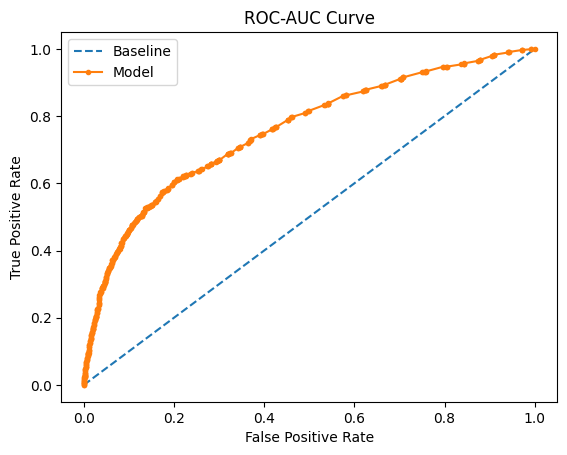

Logistic: f1=0.472 auc=0.517


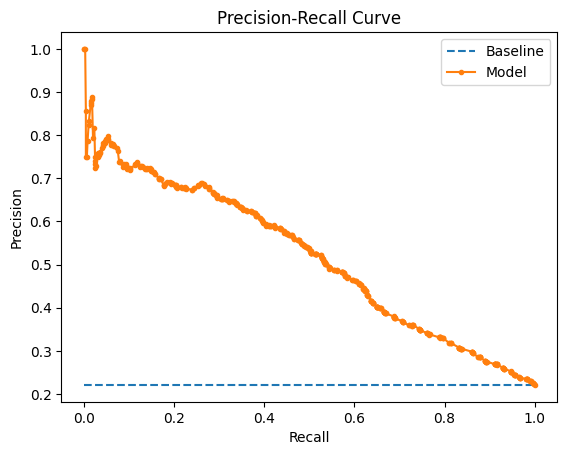

Confusion Matrix:


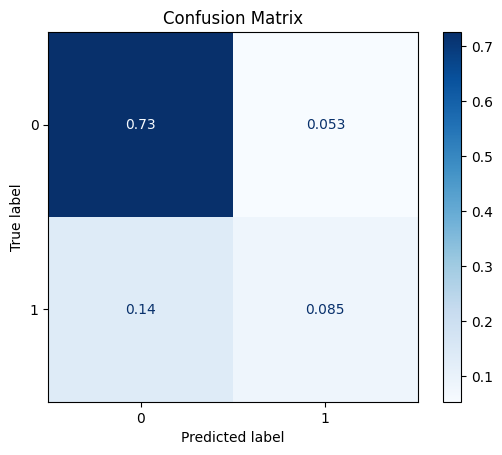

array([[0.7255    , 0.05333333],
       [0.13633333, 0.08483333]])

In [21]:
model_eval(etc, X_test, y_test)

## Combination (DecisionTree, Logistic Regression, Naive Bayes, KNN, SVM)

In [25]:
combined = VotingClassifierCustom([KNeighborsClassifier, LogisticRegression, DecisionTreeClassifier, GaussianNB, SVC], 
                                  {'SVC': {'class_weight': 'balanced', 'probability': True}})
combined.fit(X_train, y_train)

{'KNeighborsClassifier': {}, 'LogisticRegression': {}, 'DecisionTreeClassifier': {}, 'GaussianNB': {}, 'SVC': {'class_weight': 'balanced', 'probability': True}}


Training Estimators: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      4673
           1       0.57      0.47      0.52      1327

    accuracy                           0.81      6000
   macro avg       0.72      0.69      0.70      6000
weighted avg       0.79      0.81      0.80      6000

Baseline: ROC AUC=0.500
Model: ROC AUC=0.775


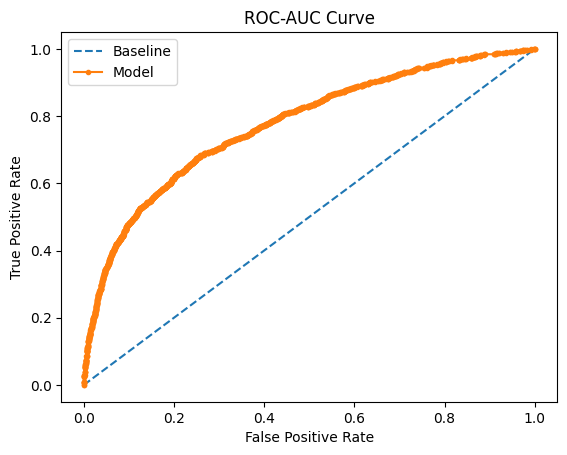

Logistic: f1=0.518 auc=0.547


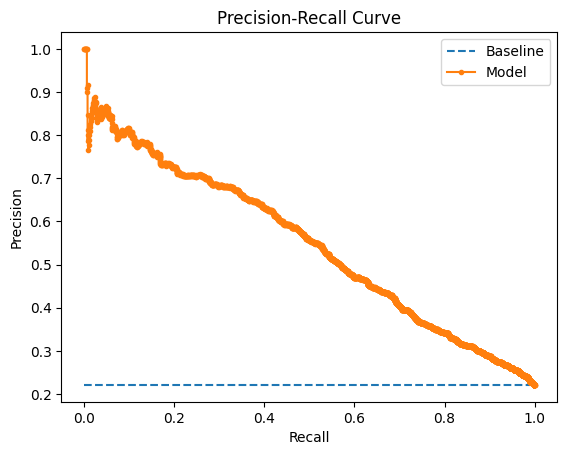

Confusion Matrix:


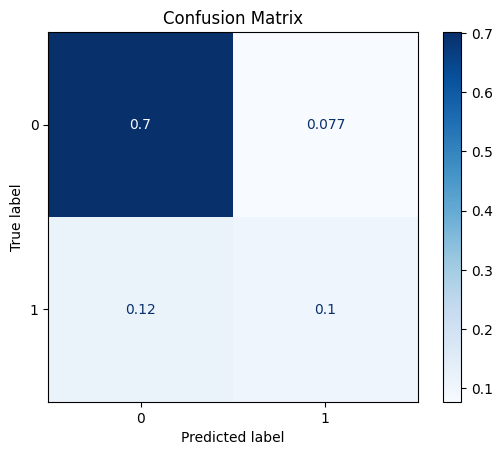

array([[0.7015    , 0.07733333],
       [0.11683333, 0.10433333]])

In [26]:
combined.predict(X_test, 'hard')
model_eval(combined, X_test, y_test, 'hard')

# Selected WOE Features + Scaled

In [27]:
selected_features = ['LIMIT_BAL','EDUCATION','AGE','PAY_3',
                     'PAY_4','PAY_5','PAY_6','BILL_AMT1',
                     'BILL_AMT2','BILL_AMT4','BILL_AMT5',
                     'BILL_AMT6','PAY_AMT1','PAY_AMT2',
                     'PAY_AMT3','PAY_AMT4', 'PAY_AMT5','PAY_AMT6']

X_woe = data[selected_features]
y_woe = data.iloc[:,-1]

Xw_train, Xw_test, yw_train, yw_test = train_test_split(X_woe, y_woe, train_size=0.8, random_state=142, stratify=y)
std = StandardScaler().fit(Xw_train)
Xw_train = std.transform(Xw_train)
Xw_test = std.transform(Xw_test)

## Logistic Regression

In [28]:
logrW = VotingClassifierCustom([LogisticRegression])
logrW.fit(Xw_train, yw_train)

{'LogisticRegression': {}}


Training Estimators: 100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


In [29]:
logrW.predict(Xw_test, 'hard')

array([0, 0, 0, ..., 0, 0, 0])

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.97      0.88      4673
           1       0.62      0.19      0.29      1327

    accuracy                           0.80      6000
   macro avg       0.72      0.58      0.59      6000
weighted avg       0.77      0.80      0.75      6000

Baseline: ROC AUC=0.500
Model: ROC AUC=0.717


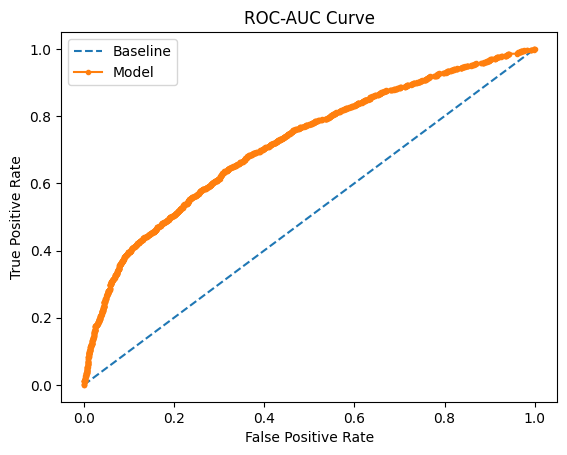

Logistic: f1=0.290 auc=0.456


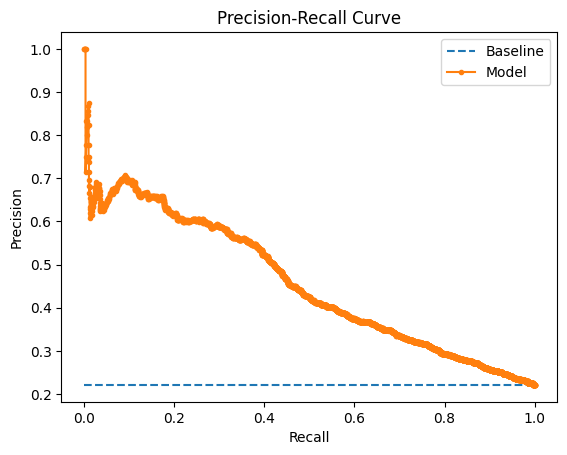

Confusion Matrix:


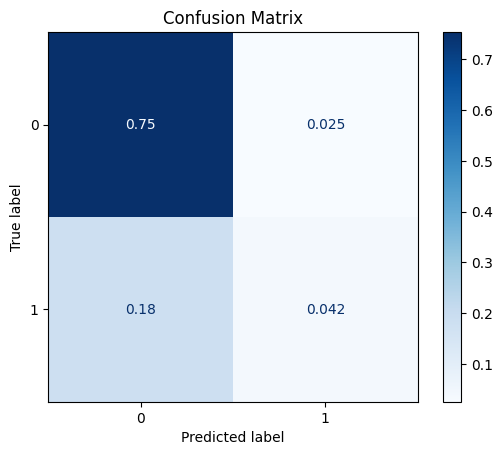

array([[0.7535    , 0.02533333],
       [0.17933333, 0.04183333]])

In [30]:
model_eval(logrW, Xw_test, yw_test, 'hard')

## Naive Bayes

In [31]:
gnbW = VotingClassifierCustom([GaussianNB])
gnbW.fit(Xw_train, yw_train)
gnbW.predict(Xw_test, 'hard')

{'GaussianNB': {}}


Training Estimators: 100%|██████████| 100/100 [00:00<00:00, 314.51it/s]


array([0, 0, 0, ..., 0, 0, 0])

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      4673
           1       0.47      0.45      0.46      1327

    accuracy                           0.77      6000
   macro avg       0.66      0.65      0.66      6000
weighted avg       0.76      0.77      0.76      6000

Baseline: ROC AUC=0.500
Model: ROC AUC=0.709


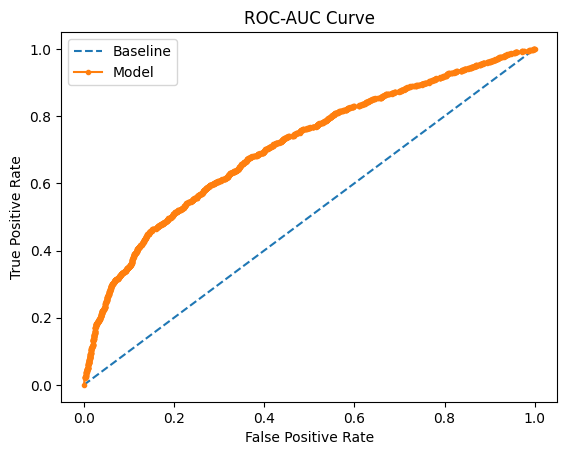

Logistic: f1=0.461 auc=0.446


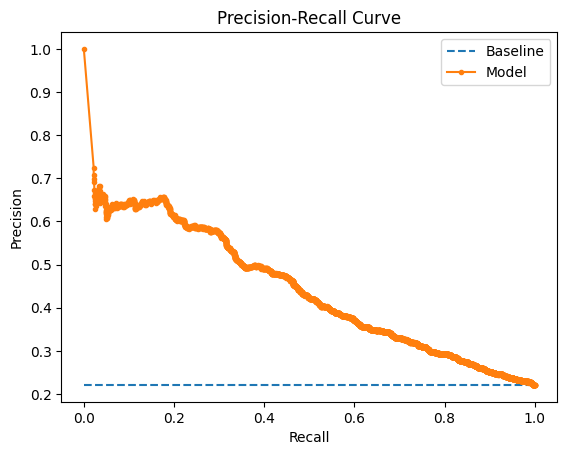

Confusion Matrix:


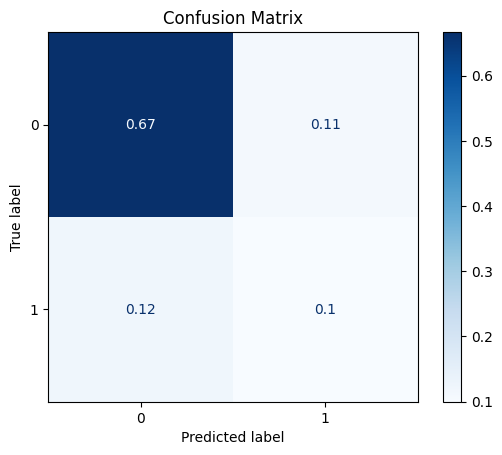

array([[0.667     , 0.11183333],
       [0.1215    , 0.09966667]])

In [32]:
model_eval(gnbW, Xw_test, yw_test, 'hard')

## KNN

In [33]:
knnW = VotingClassifierCustom([KNeighborsClassifier])
knnW.fit(Xw_train, yw_train)
knnW.predict(Xw_test, 'hard')

{'KNeighborsClassifier': {}}


Training Estimators: 100%|██████████| 100/100 [00:00<00:00, 537.38it/s]


array([0, 0, 0, ..., 0, 0, 0])

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.93      0.87      4673
           1       0.53      0.26      0.35      1327

    accuracy                           0.79      6000
   macro avg       0.67      0.60      0.61      6000
weighted avg       0.75      0.79      0.76      6000

Baseline: ROC AUC=0.500
Model: ROC AUC=0.683


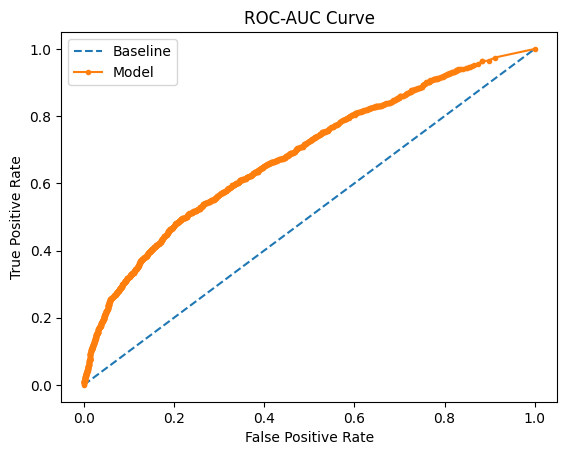

Logistic: f1=0.347 auc=0.412


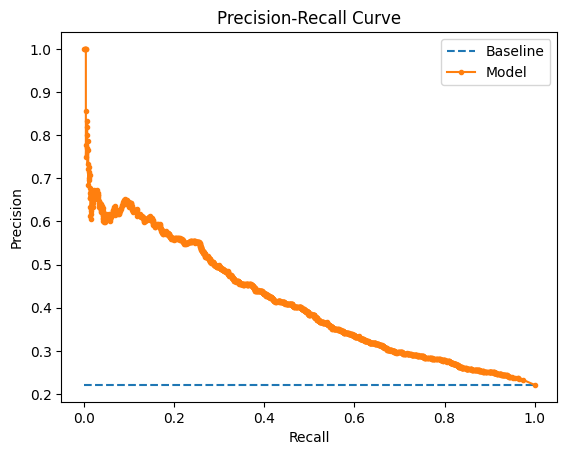

Confusion Matrix:


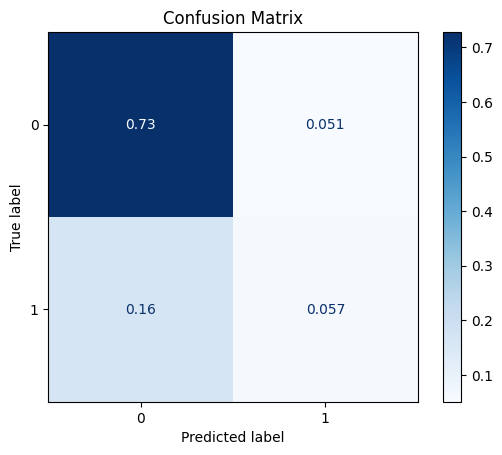

array([[0.728     , 0.05083333],
       [0.164     , 0.05716667]])

In [34]:
model_eval(knnW, Xw_test, yw_test, 'hard')

## SVM

In [35]:
SVCW = VotingClassifierCustom([SVC], {'SVC': {'class_weight': 'balanced', 'probability': True}})
SVCW.fit(Xw_train, yw_train)
SVCW.predict(Xw_test, 'hard')

{'SVC': {'class_weight': 'balanced', 'probability': True}}


Training Estimators: 100%|██████████| 100/100 [05:37<00:00,  3.38s/it]


array([0, 0, 0, ..., 1, 0, 0])

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      4673
           1       0.45      0.48      0.47      1327

    accuracy                           0.75      6000
   macro avg       0.65      0.66      0.65      6000
weighted avg       0.76      0.75      0.76      6000

Baseline: ROC AUC=0.500
Model: ROC AUC=0.731


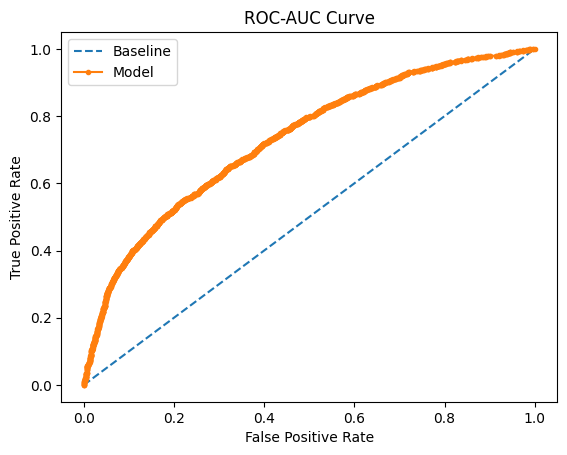

Logistic: f1=0.466 auc=0.451


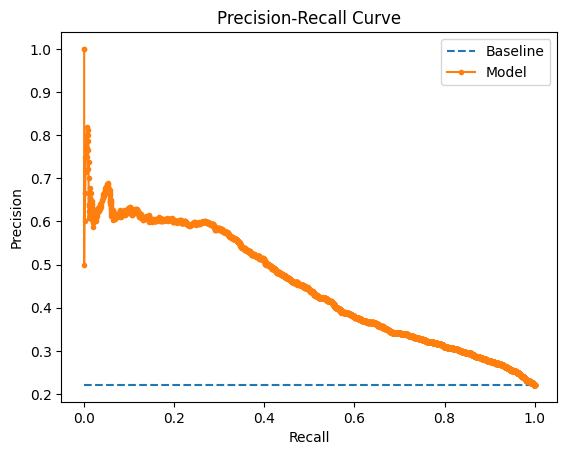

Confusion Matrix:


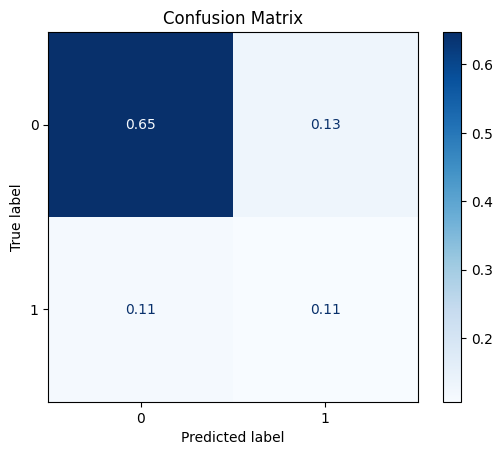

array([[0.64716667, 0.13166667],
       [0.114     , 0.10716667]])

In [36]:
model_eval(SVCW, Xw_test, yw_test, 'hard')

## Random Forest

In [37]:
rnfW = RandomForestClassifier(n_estimators=100)
rnfW.fit(Xw_train, yw_train)
rnfW.predict(Xw_test)

array([0, 0, 0, ..., 1, 0, 0])

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.94      0.88      4673
           1       0.58      0.28      0.38      1327

    accuracy                           0.80      6000
   macro avg       0.70      0.61      0.63      6000
weighted avg       0.77      0.80      0.77      6000

Baseline: ROC AUC=0.500
Model: ROC AUC=0.721


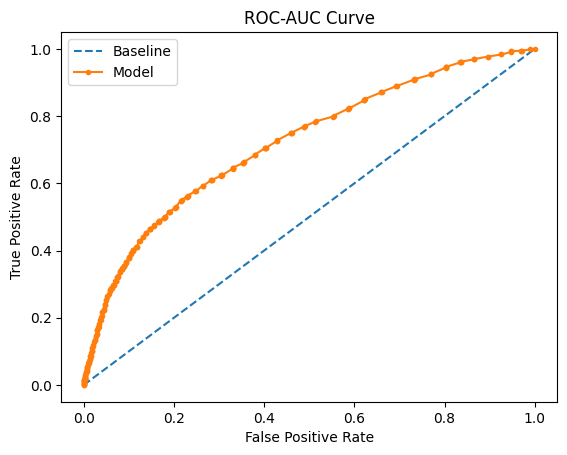

Logistic: f1=0.378 auc=0.448


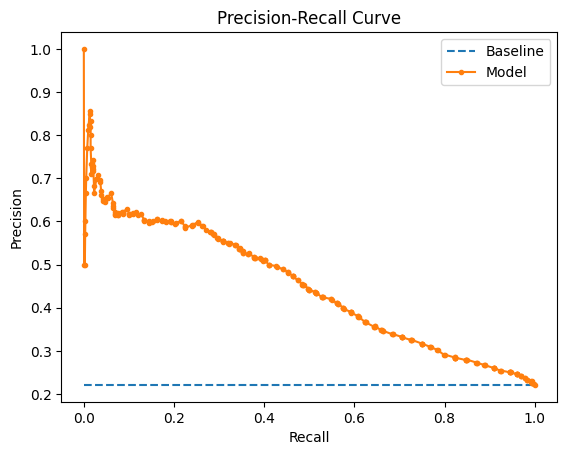

Confusion Matrix:


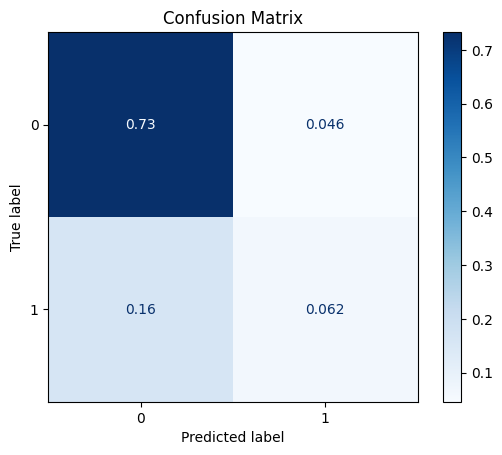

array([[0.73283333, 0.046     ],
       [0.15883333, 0.06233333]])

In [38]:
model_eval(rnfW, Xw_test, yw_test)

## Extra Trees

In [39]:
etcW = ExtraTreesClassifier(n_estimators=100)
etcW.fit(Xw_train, yw_train)
etcW.predict(Xw_test)

array([0, 0, 0, ..., 1, 0, 0])

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.94      0.87      4673
           1       0.55      0.28      0.37      1327

    accuracy                           0.79      6000
   macro avg       0.68      0.61      0.62      6000
weighted avg       0.76      0.79      0.76      6000

Baseline: ROC AUC=0.500
Model: ROC AUC=0.715


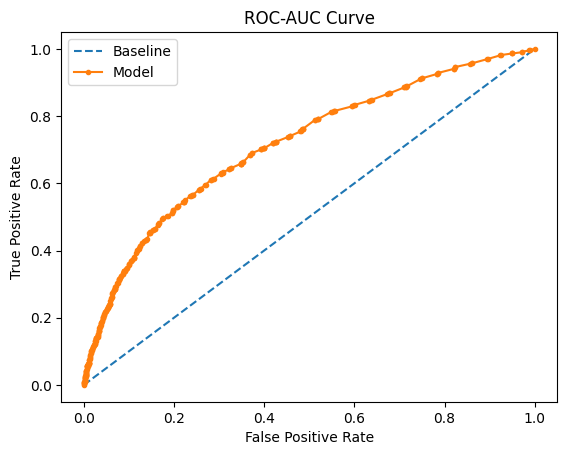

Logistic: f1=0.368 auc=0.437


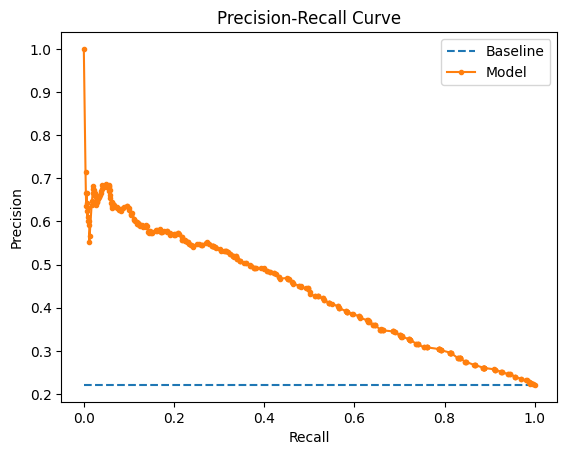

Confusion Matrix:


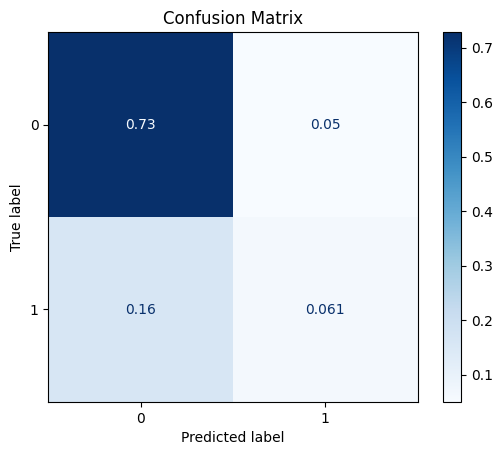

array([[0.7285    , 0.05033333],
       [0.16      , 0.06116667]])

In [40]:
model_eval(etcW, Xw_test, yw_test)

## Combination (DecisionTree, Logistic Regression, Naive Bayes, KNN, SVM)


In [41]:
combinedW = VotingClassifierCustom([KNeighborsClassifier, LogisticRegression, DecisionTreeClassifier, GaussianNB, SVC],
                                   {'SVC': {'class_weight': 'balanced', 'probability': True}})
combinedW.fit(Xw_train, yw_train)

{'KNeighborsClassifier': {}, 'LogisticRegression': {}, 'DecisionTreeClassifier': {}, 'GaussianNB': {}, 'SVC': {'class_weight': 'balanced', 'probability': True}}


Training Estimators: 100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      4673
           1       0.53      0.39      0.45      1327

    accuracy                           0.79      6000
   macro avg       0.68      0.64      0.66      6000
weighted avg       0.77      0.79      0.78      6000

Baseline: ROC AUC=0.500
Model: ROC AUC=0.731


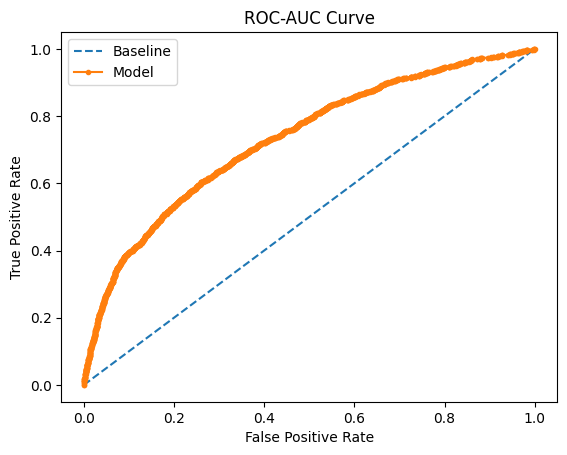

Logistic: f1=0.446 auc=0.468


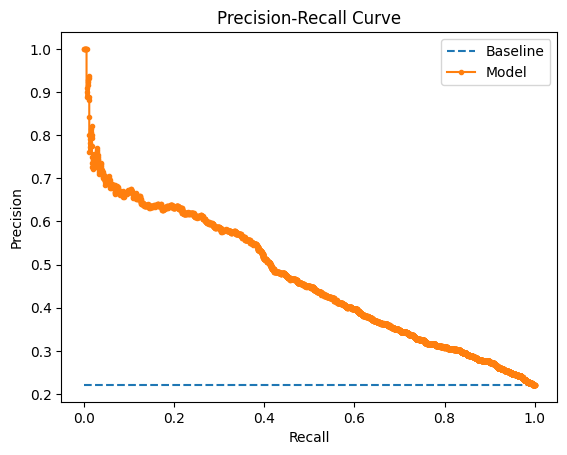

Confusion Matrix:


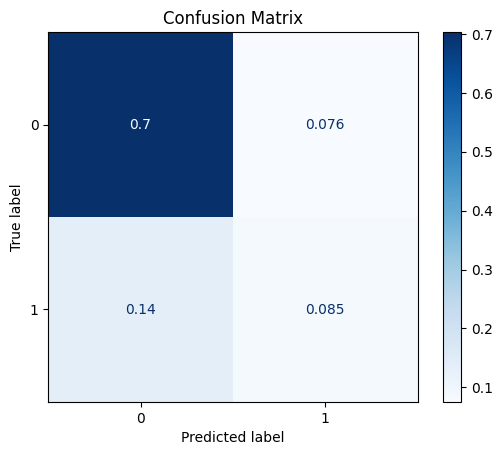

array([[0.70316667, 0.07566667],
       [0.136     , 0.08516667]])

In [42]:
combinedW.predict(Xw_test, 'hard')
model_eval(combinedW, Xw_test, yw_test, 'hard')